In [2]:
# Imports block
import torch
from einops import rearrange
from transformers import VivitImageProcessor, AutoFeatureExtractor

from common.amigos.dataset import AMIGOSDataset
from models.FEEG.layers.base_embedding import ViViTFoundationEmbedder, MiniLMFoundationEmbedder, \
    CBraModFoundationEmbedder
from models.FEEG.layers.perceiver_adapter import PerceiverResampler
from models.FEEG.model import EEGAVI

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Dataset Interaction

In [2]:
ds = AMIGOSDataset("../../resources/AMIGOS/sampled/AMIGOS_sampled.csv")
record = ds.__getitem__(1)

In [3]:
record.__dict__.keys()

dict_keys(['eeg', 'video', 'audio', 'text', 'present'])

In [4]:
import numpy as np

# Todo make them return tensors
for key in record.__dict__.keys():
    if record.__getattribute__(key) is None:
        print("None")
    else:
        i = record.__getattribute__(key)
        print("key: " + key)
        print(str(i.shape) if isinstance(i, np.ndarray) else "arr::len::" + str(len(i)))
        print("")  # Newline for clarity

eeg = record.eeg

key: eeg
(640, 17)

key: video
arr::len::77

key: audio
arr::len::2

None
key: present
arr::len::4



## Model
### Structure
We use ```make_dot``` to plot a structure of the actual model. <br>
This step is just to see if the shapes match and there were no mistakes on that behalf.

### ViViT
ViViT accepts only 32 frames sequence inputs. How to operate depends on approach:
- Uniform sampling → evenly pick 32 frames across the whole 4 s (good coverage)
- Random sampling → randomly pick 32 frames (common in training for augmentation).
- Sliding windows → split into multiple 32-frame clips (e.g. 120 frames → 3–4 clips of 32), process each, then average/aggregate.

> Sliding window could be what I need for face expressions altough more costy as I need to compute multiple times ViVIT downstream when feeding the video.

In [9]:
vivit = ViViTFoundationEmbedder()
video = torch.randint(low=0, high=256, size=(32, 3, 224, 224))

processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
a = processor(list(video), return_tensors="pt")

non_reshaped = vivit.base_model(a.pixel_values)
r = vivit(**a)

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
o = vivit.base_model(**a)

In [14]:
[ str(key) + " " + str(o[key].shape) for key in o.keys()]

['last_hidden_state torch.Size([1, 3137, 768])',
 'pooler_output torch.Size([1, 768])']

In [3]:
r.shape

torch.Size([1, 1, 16, 196, 768])

In [3]:
o = vivit.base_model(**a)

In [11]:
vivit.base_model.config.tubelet_size[-1]

16

In [9]:
o.pooler_output.shape

torch.Size([1, 768])

###  ViViT + Perceiver

In [7]:
print("Shape of video after ViViT:" + str(r.shape))
resampler_video = PerceiverResampler(768, 2, max_num_frames=32, max_num_media=32)(r)
print("After OpenFlamingo: " + str(resampler_video.shape))

Shape of video after ViViT:torch.Size([1, 1, 16, 196, 768])
After OpenFlamingo: torch.Size([1, 1, 64, 768])


In [7]:
# Fuse the time steps with the latent dimension space
R_v = rearrange(resampler_video, "b t l d -> b (t l) d")
R_v.shape

torch.Size([1, 2048, 768])

# WavLM

In [3]:
from models.FEEG.layers.base_embedding import W2VBertFoundationEmbedder

audio_processor = AutoFeatureExtractor.from_pretrained("facebook/w2v-bert-2.0")
audio = audio_processor(torch.randn(16000), padding=True, return_tensors='pt')
wavlm = W2VBertFoundationEmbedder()

It is strongly recommended to pass the `sampling_rate` argument to `SeamlessM4TFeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.


In [5]:
a = wavlm.base_model(**audio)
# odict_keys(['last_hidden_state', 'extract_features'])

In [8]:
a["last_hidden_state"].shape

torch.Size([1, 49, 1024])

In [12]:
wavlm

{'input_features': tensor([[[-0.1592,  0.5624,  1.4083,  ...,  1.4783, -0.8547, -0.8763],
         [ 1.2123, -1.8793, -0.4854,  ...,  0.2755,  0.4648, -0.5399],
         [ 0.4843,  0.2714, -0.1503,  ...,  0.3840, -0.2497, -0.9086],
         ...,
         [-0.4710, -0.8578,  0.9055,  ...,  0.2753,  0.2492,  1.8739],
         [ 0.1926,  0.4783,  0.3498,  ..., -0.8448, -2.1798,  1.5988],
         [ 0.2215,  0.0423, -0.0263,  ..., -0.2740,  0.4701,  0.1755]]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], dtype=torch.int32)}

In [14]:
y = wavlm(**audio)
print("Shape after WavLM: " + str(y.shape))
resampled = PerceiverResampler(1024, 2)(y)
print("Simple perceiver:" + str(resampled.shape))

Shape after WavLM: torch.Size([1, 1, 49, 1, 1024])
Simple perceiver:torch.Size([1, 1, 64, 1024])


In [15]:
R_a = rearrange(resampled, "b t l d -> b (t l) d")
R_a.shape

torch.Size([1, 64, 1024])

In [16]:
# The gated attn is fed with the concatenation of the aux embeddings.
torch.cat([R_v, R_a], dim=1).shape

NameError: name 'R_v' is not defined

## MiniLM

In [ ]:
minilm = MiniLMFoundationEmbedder()

In [ ]:
from transformers import AutoTokenizer

inputs = "This is a text test"
minilm_processor = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
a = minilm_processor(inputs, padding=True, truncation=True, return_tensors='pt')

In [ ]:
a

In [ ]:
res = minilm(**a)
res.shape

In [ ]:
from torch import nn

text_resampled = PerceiverResampler(384, 2)(res)
R_t = rearrange(text_resampled, "b t l d -> b (t l) d")
print(R_t.shape)  # Shape mismatch for building the input

# For mismatch simply project to correct feature space.
o = nn.Linear(384, 768)(R_t)
o.shape

## CBraMod


In [5]:
cbramod = CBraModFoundationEmbedder()
# mock_eeg.shape = (batch_size, num_of_channels, time_segments, points_per_patch)
x_eeg = torch.randn(1, 22, 4, 200)
res = cbramod(x=x_eeg)

x_eeg.shape

torch.Size([1, 22, 4, 200])

In [5]:
from scipy.signal import resample_poly
import mne

# TODO move this stuff elsewhere
# TODO Should I resample to 200Hz? Like the way it does in CBraMod. Non sembra ideale. Meglio paddare.

x_eeg = torch.Tensor(eeg.T).unsqueeze(0)
print(x_eeg.shape)  # Sampled has fused timesteps with D. We can retrieve it the right way:

# 5s time steps as per setup. This will change
x_eeg = rearrange(x_eeg, "b c (t d) -> b c t d", t=5)
mne_eeg = mne.io.RawArray(eeg.T, info=mne.create_info(sfreq=128,
                                                      ch_names=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K",
                                                                "L", "M", "N", "O", "P", "Q"]))

print(x_eeg.shape)

# TODO masking servita per segments corti (ora sono fissi)
x_eeg = resample_poly(x_eeg, up=25, down=16, axis=-1)  # shape: [B, C, T * 25/16]
x_eeg = torch.Tensor(x_eeg)
# mask = torch.ones([17, 5, 128])
# mask = F.pad(mask, (0, 200 - mask.shape[-1]))
# print(mask.shape)  # Damn mi sa che la maschera era per timesteps only! todo caprie

torch.Size([1, 17, 640])
Creating RawArray with float64 data, n_channels=17, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.
torch.Size([1, 17, 5, 128])


Using matplotlib as 2D backend.


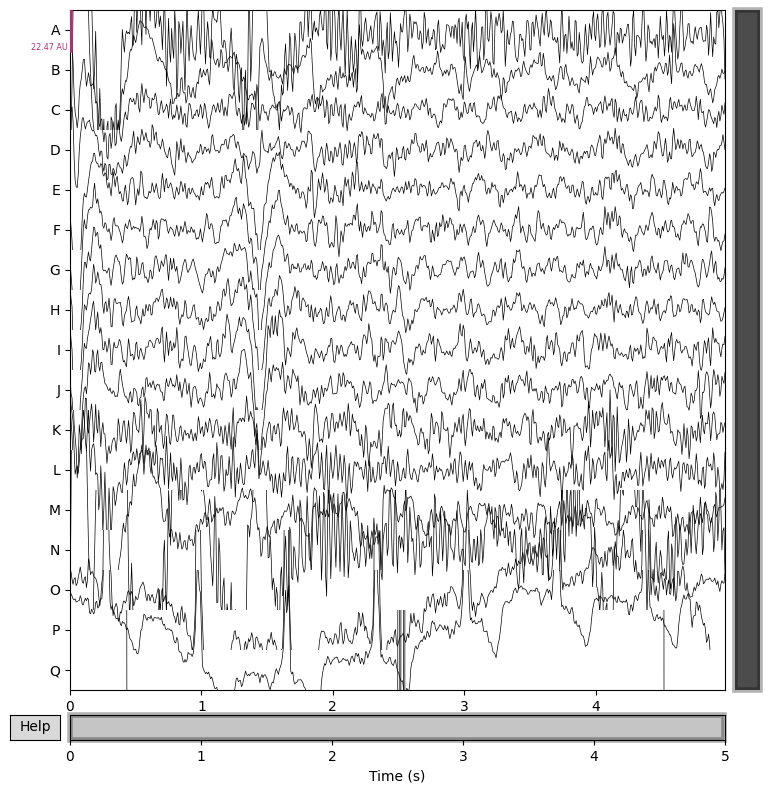

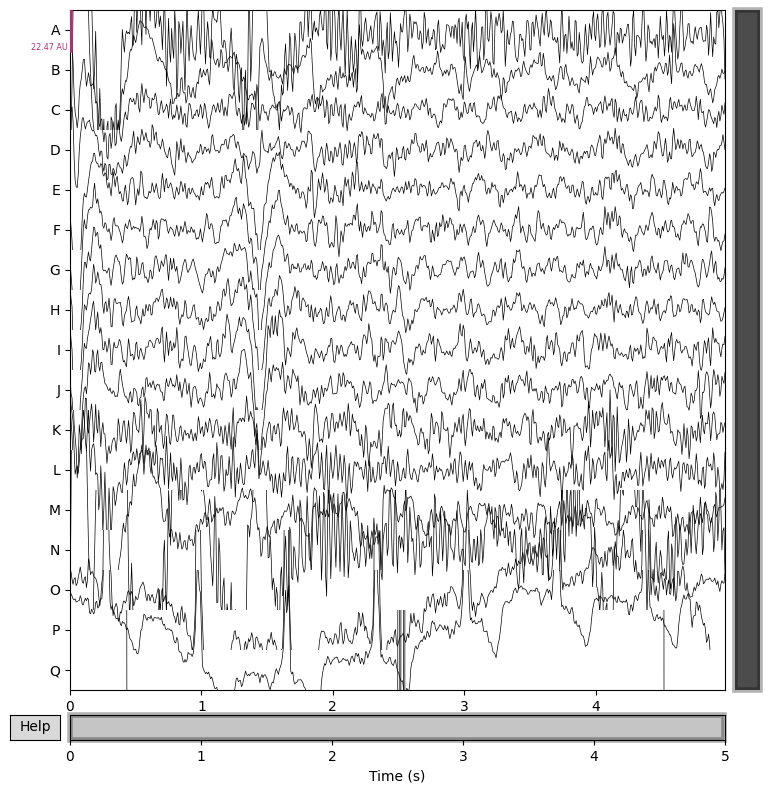

In [6]:
mne_eeg.plot()

Polyphase resampling neighborhood: ±2 input samples


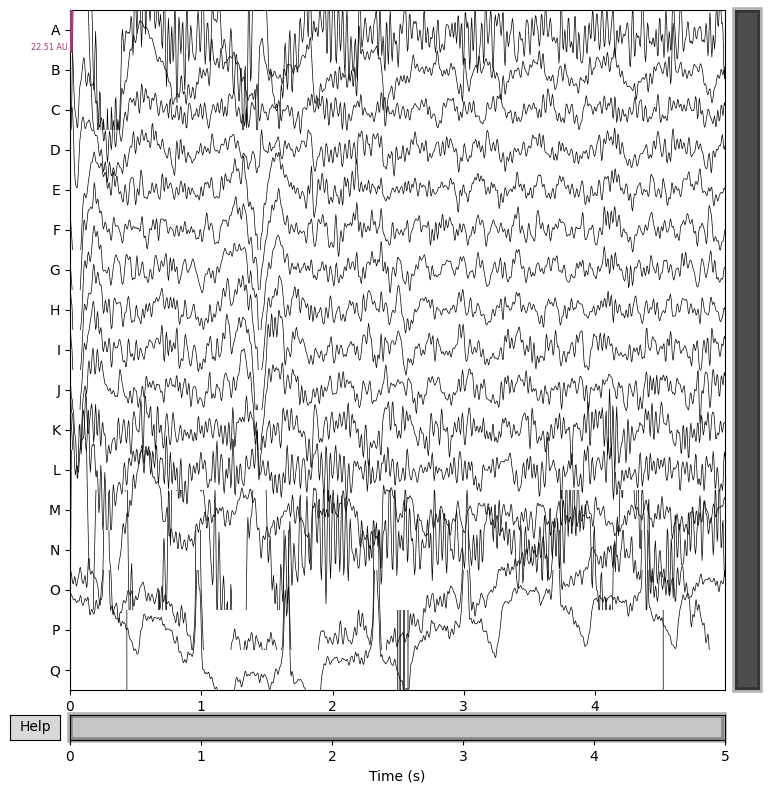

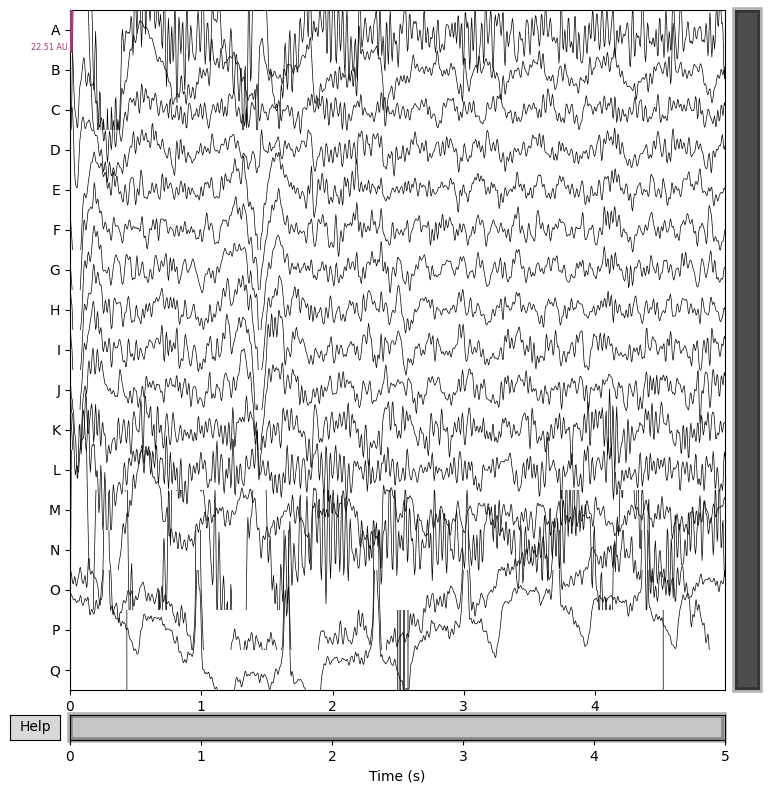

In [7]:
mne_eeg.resample(200, method="polyphase", npad="auto")
mne_eeg.plot()

In [8]:
x_eeg = torch.Tensor(mne_eeg.get_data()).unsqueeze(0)
x_eeg = rearrange(x_eeg, "b c (t d) -> b c t d", t=5)

In [9]:
x_eeg.shape

torch.Size([1, 17, 5, 200])

In [10]:
cbramod = CBraModFoundationEmbedder()
# mock_eeg.shape = (batch_size, num_of_channels, time_segments, points_per_patch)
res = cbramod(x=x_eeg, mask=None)

In [17]:
res.shape
# todo make mask x object for cbramod

torch.Size([1, 17, 5, 200])

## Main Model

In [ ]:
# Load an EEG sample

In [10]:
# Model initialization
model = EEGAVI(
    resampler_depth=2,
    text_kd_size=100,
    video_kd_size=100,
    audio_kd_size=100
)

processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
# Build input x as:
video = torch.randint(low=0, high=256, size=(32, 3, 224, 224))
x_vid = processor(list(video), return_tensors="pt")

processor = AutoFeatureExtractor.from_pretrained("facebook/w2v-bert-2.0")
x_aud = processor(torch.randn(1, 16000), return_tensors="pt")

x_tex = None  # We try without text

It is strongly recommended to pass the `sampling_rate` argument to `SeamlessM4TFeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.


In [11]:
x_vid.keys()

dict_keys(['pixel_values'])

In [13]:
y = model(({"x": x_eeg}, x_vid, x_aud, x_tex))

KeyboardInterrupt: 

In [17]:
y

(tensor([[[ 0.1115, -0.3159,  0.3026,  ...,  0.0255,  0.1965, -0.2514],
          [ 0.0063, -0.3036,  0.1800,  ..., -0.0544,  0.0099, -0.3136],
          [ 0.0914, -0.1650,  0.0126,  ..., -0.1485, -0.3068,  0.0636],
          ...,
          [-0.0715, -0.2298,  0.3455,  ...,  0.1038, -0.0349, -0.0782],
          [-0.0291, -0.2829,  0.3380,  ...,  0.1279,  0.0685, -0.0919],
          [ 0.0394, -0.2831,  0.1713,  ...,  0.0928,  0.1257, -0.1792]]],
        grad_fn=<ViewBackward0>),
 {'kd_ve': tensor([[[[ 0.0900, -0.0449,  0.0507,  ..., -0.0250,  0.0150, -0.0004],
            [ 0.0196, -0.0519,  0.0194,  ...,  0.0623,  0.0006, -0.1379],
            [ 0.0313,  0.0162,  0.0109,  ...,  0.0228,  0.0244,  0.0056],
            ...,
            [ 0.0590, -0.0143,  0.0705,  ...,  0.0194,  0.0732,  0.0302],
            [ 0.0834, -0.0521,  0.0703,  ...,  0.0492,  0.0430, -0.0229],
            [ 0.0671, -0.0189, -0.0054,  ...,  0.0186,  0.0582,  0.0307]]]],
         grad_fn=<DivBackward0>),
  'kd_ae':

In [13]:
y[0].shape

torch.Size([1, 85, 384])

In [13]:
y[0].shape

torch.Size([1, 85, 384])

In [16]:
({"x": x_eeg}, x_vid, x_aud, x_tex)

({'x': tensor([[[[ 1.0505e+02,  1.4146e+02,  1.9138e+02,  ...,  7.1473e-02,
             -9.3070e+00, -9.2528e+00],
            [ 2.3181e+00,  1.9462e+01,  3.0990e+01,  ..., -1.5601e+01,
             -1.3881e+01,  2.4012e+00],
            [ 1.6780e+01,  2.1607e+01,  1.9287e+01,  ...,  6.4920e+00,
             -5.4720e+00, -1.7034e+01],
            [-1.4530e+01,  1.2553e-01,  1.2540e+01,  ...,  1.2568e+01,
              4.1012e+00, -3.4366e+00],
            [-3.2216e+00,  3.6830e+00,  1.0665e+01,  ..., -2.4714e+01,
             -1.7810e+01, -1.8711e+01]],
  
           [[-4.8953e+01, -4.3153e+01, -2.8614e+01,  ...,  9.7299e-01,
              3.2360e+00,  9.9021e-01],
            [-2.4216e+00, -2.9028e+00, -3.0020e-01,  ..., -7.2752e-01,
             -8.4670e-01, -2.9344e+00],
            [-6.1664e+00, -8.2733e+00, -6.5720e+00,  ..., -1.3401e+01,
             -1.6192e+01, -1.0722e+01],
            [ 3.9146e-01,  8.3382e+00,  8.0013e+00,  ...,  1.8659e+00,
              2.6366e+00,  2.478

In [ ]:
from torchview import draw_graph

# Love this library !
model_graph = draw_graph(model, input_data={"x": ({"x": x_eeg}, x_vid, x_aud, x_tex)}, device='meta', depth=3,
                         expand_nested=True)
model_graph.visual_graph

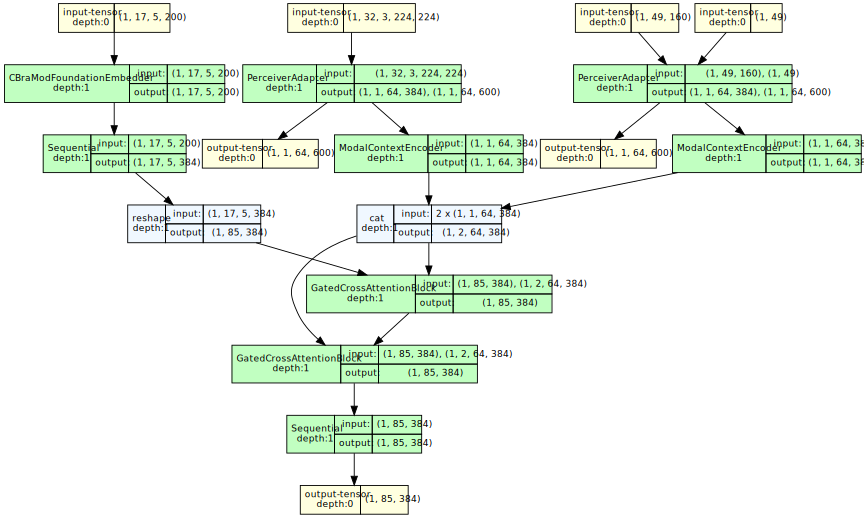

In [14]:
from torchview import draw_graph

# Love this library !
model_graph = draw_graph(model, input_data={"x": ({"x": x_eeg}, x_vid, x_aud, x_tex)}, device='meta', depth=1)
model_graph.visual_graph

In [11]:
total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameter count is: {total_params}. Trainable parameter count is: {trainable}")

Total parameter count is: 741284156. Trainable parameter count is: 43916828


In [13]:
from collections import defaultdict

bucket = defaultdict(int)
for name, p in model.named_parameters():
    if p.requires_grad:
        top = name.split('.', 1)[0]  # e.g., 'fusion', 'base_video'
        bucket[top] += p.numel()

for k, v in sorted(bucket.items(), key=lambda x: -x[1])[:10]:
    print(f"{k:24s} {v:,}")

audio_adapter            22,070,232
video_adapter            13,407,192
text_adapter             4,196,952
gatedXAttn_layers        3,562,756
projector                591,744
eeg_shape_adapter        77,584
eeg_aux_encoder          8,448
modal_encoder            1,920


In [ ]:
# next this:
# todo
# review cross attention + rerun per vedere se si è rotto.
# Trainer + loss + KD

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import layers.base_layers
import importlib

importlib.reload(layers.base_layers)
from layers.base_layers import QueryEEGFormer



former = QueryEEGFormer(200, 384, 10, 20)

former(res).shape

torch.Size([1, 85, 384])

Great question. In OpenFlamingo-style **MaskedCrossAttention**, `media_locations` is a boolean **over the query sequence** that marks **where a new media item begins**. The layer then maps each query time step to its **most recent** media item (or **all previous** ones, depending on the flag). In the original Flamingo, these `True` positions are where the special `<image>` tokens appear in the text. ([GitHub][1], [Hugging Face][2])

Here’s how to build it for your EEG-as-query setup.

---

# What the mask means

Given:

* `qo`: your query tokens, shape **(B, Tq, Dq)** (e.g., EEG tokens over time; if you use *time×channel* then Tq = T\*C),
* `kvo`: your media latents, shape **(B, T\_item, n, Dk)** (T\_item = number of media **items** — images or clips),

you need **`media_locations: (B, Tq)`** such that:

* `media_locations[b, t] == True` exactly at timesteps `t` where **item boundaries** occur (the first time each media item is introduced).
* Inside the layer, `q_time = cumsum(media_locations)` yields the “index” of the latest available media for each query step; queries before the first `True` have `q_time=0` and therefore attend to **no media** when `only_attend_immediate_media=True`. ([Hugging Face][2])

---

# Typical cases & code

## Case A — one media item for the whole EEG window (most common)

You want every query to be allowed to attend to that one item.

```python
def media_locs_single_item(B, Tq, device):
    m = torch.zeros(B, Tq, dtype=torch.bool, device=device)
    m[:, 0] = True            # item “introduced” at t=0
    return m
```

Call:

```python
media_locations = media_locs_single_item(B=qo.size(0), Tq=qo.size(1), device=qo.device)
out = xattn(qo, kvo, media_locations=media_locations, use_cached_media=False)
```

> If you pass `media_locations=None`, set `use_cached_media=True` to bypass the shape assert and pretend every query happens **after** the last media item (useful for caching; all queries attend to the cached item). ([Hugging Face][2])

## Case B — multiple media items on a timeline

You have `T_item` clips/images and you know their **start indices** on the EEG query timeline: `starts = [t0, t1, ..., t_{T_item-1}]` with `0 ≤ t_i < Tq`.

```python
def build_media_locations_from_starts(B, Tq, starts, device):
    m = torch.zeros(B, Tq, dtype=torch.bool, device=device)
    idx = torch.as_tensor(starts, device=device, dtype=torch.long)
    m[:, idx] = True
    return m

# Example: three clips starting at 0, 40, 80
media_locations = build_media_locations_from_starts(B, Tq, [0, 40, 80], qo.device)
out = xattn(qo, kvo, media_locations=media_locations, use_cached_media=False)
```

* With `only_attend_immediate_media=True`, each query `t` attends **only to** the most recent item (mask uses equality on that cumulative index).
* With it set **False**, a query attends to **all previous items** (mask uses ≥). ([Hugging Face][2])

## Case C — your queries are **time×channel** tokens

If you flattened `(B, C, T, D)` into `(B, T*C, D)` **time-major**, just **repeat the time mask across channels**:

```python
# base time mask of shape (B, T)
m_time = media_locs_single_item(B, T, qo.device)         # or build from starts
# expand to (B, T*C) to match qo flattened as (B, T*C, D)
media_locations = m_time.repeat_interleave(repeats=C, dim=1)
```

This way, all channel tokens at time `t` share the same “item index”.

---

# Sanity checks

* `media_locations.shape == (B, Tq)` must match the **query length** (not `kvo`).
* If some queries occur **before** any item is introduced (all `False` up to `t`), they won’t be allowed to attend when `only_attend_immediate_media=True`. If that’s not desired, introduce your first item at `t=0` (as in Case A).
* If you concatenate multiple modalities in `kvo`, concatenate along **`n`** (the latent axis), **not** along `T_item`. All modalities in a given **item slot** are available at the same time index. (If their item counts differ, pad/align to a shared `T_item`.)

---

# Minimal drop-in utility

```python
def make_media_locations(Tq, item_starts, B=1, device="cuda"):
    """
    item_starts: iterable of length T_item with start indices (0-based) for each media item
    returns: (B, Tq) boolean mask
    """
    m = torch.zeros(B, Tq, dtype=torch.bool, device=device)
    if len(item_starts) == 0:
        # fallback: treat as already cached
        return m  # but then call xattn with use_cached_media=True
    idx = torch.as_tensor(item_starts, device=device, dtype=torch.long)
    m[:, idx.clamp_(0, Tq-1)] = True
    return m
```

---

# How this mirrors OpenFlamingo

In OpenFlamingo, text tokens contain `<image>` markers; `media_locations[b, t]` is **True** exactly where those tokens sit. The cross-attn layer converts that boolean vector into a cumulative “media index per query” and masks attention to either the **immediately preceding** or **all previous** media items. You’re doing the same—but your **queries are EEG timesteps** instead of text tokens. ([GitHub][1], [Hugging Face][2])

If you share how you segment your EEG window vs. media items (e.g., one clip per window or many), I can give you the exact `item_starts` to pass for your shapes.

[1]: https://github.com/mlfoundations/open_flamingo "GitHub - mlfoundations/open_flamingo: An open-source framework for training large multimodal models."
[2]: https://huggingface.co/Infi-MM/infimm-hd/raw/af3d978efd5292624c1ce80dee50bf8cb6d11275/flamingo_lm.py?utm_source=chatgpt.com "https://huggingface.co/Infi-MM/infimm-hd/raw/af3d9..."


Great questions — you’re basically at the “add the heads & poolers” step.

## 1) From `[b, 1, 64, 384]` to `[b, 100]` for KD

Think of the Perceiver output as **64 latent tokens** of width 384 (the leading `1` is just “num media streams”). For KD you just need a **global vector** per sample, then a **logit layer**.

**Simple & solid recipe**

```python
x = perceiver_out            # [b, 1, 64, 384]
x = x.squeeze(1)             # [b, 64, 384]

# pool tokens -> one vector
pooled = x.mean(dim=1)       # [b, 384]  (or use attention pooling; see below)

# KD head
kd_logits = nn.Linear(384, 100)(pooled)   # [b, 100]
```

**Attention pooling (often a tiny win)**

```python
class AttnPool(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.gate = nn.Linear(d, 1)  # token score
    def forward(self, x):             # x: [b, T, d]
        a = torch.softmax(self.gate(x).squeeze(-1), dim=1)  # [b, T]
        return (a.unsqueeze(1) @ x).squeeze(1)              # [b, d]
```

Then do `pooled = AttnPool(384)(x)` and the same `Linear(384→100)`.

**KD loss reminder (PyTorch)**

```python
T = 2.0  # temperature
loss_kd = torch.nn.functional.kl_div(
    torch.log_softmax(kd_logits / T, dim=-1),
    torch.softmax(teacher_logits / T, dim=-1),
    reduction="batchmean"
) * (T * T)
```

(Ensure the teacher’s 100 categories match your KD head’s 100.)

> Tip: Keep the KD head **separate** from whatever head you use after cross-attention. Share the backbone, have different heads, and combine losses: `L = α·L_kd + β·L_ssl + …`.

---

## 2) What “patches” are (and why you have 85 of them)

A **patch** is just a **local chunk turned into one token**.

* For images: a 16×16 crop → 1 token.
* For EEG/time: a **window of samples** (e.g., 200 ms with some stride) — possibly per channel or after a channel-mixing layer — → 1 token.

So `[b, 85, 384]` means you currently have **85 tokens** (85 local windows) each with a 384-D embedding. The exact 85 comes from your patch/window size, stride, and any channel grouping; it’s the count of windows your embedding layer produced.

---

## 3) Are `[b, 85, 384]` “good embeddings”, or reduce to `[b, E]`?

Both are useful — pick based on the next step:

* **Keep sequence `[b, 85, 384]`** if you’ll:

  * do more transformer layers / cross-attention,
  * use token-level losses (e.g., masked modeling, alignment at specific times).

* **Reduce to a vector `[b, E]`** if you need:

  * clip-level classification, retrieval, KD, logging to disk, etc.

**Common ways to reduce**:

* Mean pooling: fast, stable.
* Attention pooling (above): learn to weight important tokens.
* CLS token: add one learnable token and read it out.
* Small MLP head: `LayerNorm → Linear(384→E) → GELU → Linear(E→E)` if you want a specific E (e.g., 256).

You can also keep **both**: pass the sequence forward, and in parallel keep a pooled vector for KD/metrics.

---

### Minimal, practical wiring

* **KD head (from Perceiver)**: `squeeze → pool → Linear(384→100)`.
* **Fusion path**: keep `[b, 85, 384]` for cross-attention; pool **after** fusion if a global output is needed.
* If you ever change widths, add a tiny adapter: `LayerNorm → Linear(in→out)`.

That’s it — you don’t need to reshape into anything fancy for KD; just pool then a single linear layer.


Yes—it’s totally fine. You don’t need an EEG teacher to use a CLIP-style objective with your **EEG-anchored fused stream**. You can contrast the fused embedding against **video/audio/text teacher embeddings** only. Here are solid ways to do it (pick one):

## A) Fused → multi-teacher contrast (simple & effective)

* Pool your fused tokens $(b,T,D)$ to a global vector $z_f\in\mathbb{R}^D$ (mean/attn pool + L2-norm).
* For each available teacher $t_m$ $(m\in\{\mathrm{vid},\mathrm{aud},\mathrm{text}\})$, L2-normalize and do retrieval **from $z_f$ to $t_m$**.
* Because you have **multiple positives** for the same $z_f$, use a **Sigmoid (SigLIP-style) pairwise loss** or multi-positive InfoNCE.

**Loss (Sigmoid, per teacher, summed over m):**

$$
\mathcal{L}_{\text{sig}}^{(m)}=\text{BCE}(\sigma(s_{ii}^{(m)}),1)+\!\!\sum_{j\ne i}\!\text{BCE}(\sigma(s_{ij}^{(m)}),0),\quad
s_{ij}^{(m)}=\tfrac{1}{\tau_m} z_f^{(i)}\!\cdot\! t_m^{(j)}
$$

Use a **separate temperature $\tau_m$** (or learnable `logit_scale_m`) per teacher.

**Why this works:** your fused vector has three paired targets (v/a/t) for the same sample; in-batch others are negatives. No EEG teacher needed.

## B) Tiny per-teacher heads (avoid space mismatch)

Teacher spaces differ. Two tidy options:

* Map **teachers → shared space**: learn small adapters $A_m$ so $s_m=A_m t_m$ live in the same space as $z_f$; do A) on $\{s_m\}$.
* Map **fused → each teacher space**: heads $h_m$ predict $\hat t_m=h_m(z_f)$; train with cosine/MSE or CRD vs. $t_m$. Keep only $z_f$ at inference.

## C) Structure-aware KD (extra stability, optional)

* **CRD:** contrast $z_f$ against $\{t_m\}$ with in-batch teacher negatives (transfers neighborhood structure).
* **RKD/SPKD:** match pairwise geometry (distances/similarities) between $\{z_f\}$ and $\{t_m\}$ per batch.
* **EMA self-teacher for fused:** keep a momentum copy of your fused encoder and add a small cosine term $1-\cos(z_f,\;\text{sg}(z_f^{\text{ema}}))$ to reduce drift toward any single teacher.

## Practical recipe (what I’d start with)

* L2-normalize all embeddings.
* Attention-pool fused tokens → $z_f$.
* Per-teacher learnable `logit_scale_m` and **Sigmoid pairwise** loss; weight by trust, e.g. $\lambda_v=0.4,\lambda_a=0.35,\lambda_t=0.25$.
* Add tiny **teacher→shared** adapters $A_m$ before contrast (or fused→teacher heads—either works; adapters keep $z_f$ unified).
* Optional small **cosine KD** and **RKD** for stability.

### Minimal PyTorch sketch (multi-teacher Sigmoid)

```python
# zf: (B,D) fused pooled; tv, ta, tt: (B,D) teachers; all L2-normalized
def siglip(z, t, logit_scale):
    sim = logit_scale * (z @ t.t())               # (B,B)
    pos = sim.diag()
    pos_loss = torch.nn.functional.binary_cross_entropy_with_logits(pos, torch.ones_like(pos))
    neg = sim[~torch.eye(sim.size(0), dtype=torch.bool, device=sim.device)]
    neg_loss = torch.nn.functional.binary_cross_entropy_with_logits(neg, torch.zeros_like(neg))
    return pos_loss + neg_loss

loss = (
    0.4 * siglip(zf, tv, torch.exp(logit_scale_v)) +
    0.35 * siglip(zf, ta, torch.exp(logit_scale_a)) +
    0.25 * siglip(zf, tt, torch.exp(logit_scale_t))
)
# optional: + 0.2 * (1 - (zf * zf_ema).sum(-1).mean())  # EMA self-distill
```

**Bottom line:** You can train your single fused encoder perfectly well using only **video/text/audio teachers**. Align the fused embedding to those spaces (contrastive + light KD), and you’re good—no EEG teacher required.


Great q — and you’re thinking about exactly the right failure mode.

## First: your loss intuition (tiny correction)

Don’t do BCE on “vector differences.” Do **BCE on pairwise similarities** (dot-product or cosine) between your fused embedding $z_f$ and teacher embeddings $t_m$ (m ∈ {video, audio, text}). That’s the **SigLIP** style loss:

$$
S^{(m)} = \mathrm{logit\_scale}_m \cdot (Z_f\,T_m^\top)\quad;\quad
\mathcal{L}^{(m)}=\text{BCEWithLogits}(S^{(m)}, Y),\ \ Y_{ii}=1,\ Y_{i\neq j}=0
$$

So yes: positives are $(z_f^i,t_m^i)$; all other pairs in the batch are negatives. This is exactly the “sigmoid pairwise” contrastive setup, robust to multi-positives and batch size. ([CVF Open Access][1], [arXiv][2])

## Does this guarantee you learn from EEG?

**Not by itself.** With $z_f$ produced by EEG-queries over KV={video,audio,text}, the model could minimize the teacher loss by mostly **copying KV information**, using EEG only as a weak pointer. Flamingo’s gated cross-attention makes that easy if unconstrained. ([NeurIPS Proceedings][3], [SciSpace][4])

### How to make EEG *causally matter*

Add one or more of these (lightweight) constraints:

1. **Modality dropout / masking (strongest & simple).**
   Randomly zero / drop each non-EEG modality during training (and sometimes drop **all** KVs), *while still applying the teacher contrastive loss*. This forces the model to map **EEG→teacher space** when auxiliaries are missing, preventing a KV-only shortcut. You can ramp the drop prob from 0.2→0.6 over training. Variants of modality dropout are standard to avoid over-reliance on any stream. ([arXiv][5], [CVF Open Access][6])

2. **Capacity bottleneck on cross-modal flow.**
   Limit KV→EEG bandwidth with **bottleneck tokens / Perceiver-style resampler** (small latent count), or MBT-style fusion bottlenecks. This prevents simply piping the whole teacher signal through to $z_f$. ([arXiv][7], [Google Research][8])

3. **EEG-only self-supervision (small weight).**
   Add an EEG-only SSL term so $z_f$ must retain EEG information: e.g., **CPC** across time on EEG tokens, or masked-reconstruction (MAE-style) on EEG. Even a tiny weight (λ≈0.1) is enough to anchor learning in EEG. ([arXiv][9])

4. **Regularize the gate / cross-attn.**
   Put an $\ell_1$ penalty on the **gating scalars** (from the gated cross-attn) or on the cross-attn output norm, to discourage always-open gates. Keep teacher encoders **frozen** (no gradients into them).

5. **Mismatched-KV negatives (optional).**
   Do a second forward pass where you **shuffle KVs** across samples; add a term that pushes $(z_f, t_m)$ apart under mismatched KVs. If EEG isn’t informative, the model will fail this check.

### Quick recipe that works in practice

* Use **SigLIP** losses fused→{video,audio,text} (separate temperatures per modality). ([CVF Open Access][1])
* **Modality dropout** on KV with scheduled probability; once per batch, also run an **EEG-only** pass and apply the same teacher loss. ([arXiv][5])
* Keep a tiny **EEG-SSL** term (CPC or masked-recon) on the EEG tokens. ([arXiv][9])
* Use a small **bottleneck** (e.g., 16–32 resampled tokens) for KV. ([arXiv][7])

### How to verify EEG is used (sanity checks)

* **Leave-one-modality-out** eval: drop KVs at test time and measure the retrieval/ downstream drop; the model should still perform > chance.
* **Saliency/grad norms** wrt EEG tokens should be non-trivial.
* **Performance vs. drop-prob** curves: if training worked, curves degrade gracefully when KVs are removed.

---

**Bottom line:** Your BCE/contrastive idea is right—but it **doesn’t** ensure EEG contributes unless you block shortcuts. Combine **multi-teacher SigLIP** with **modality dropout** (plus a tiny EEG-only SSL and/or **bottlenecks**) to make $z_f$ genuinely EEG-grounded while still leveraging video/audio/text. ([CVF Open Access][1], [arXiv][5])

[1]: https://openaccess.thecvf.com/content/ICCV2023/papers/Zhai_Sigmoid_Loss_for_Language_Image_Pre-Training_ICCV_2023_paper.pdf?utm_source=chatgpt.com "Sigmoid Loss for Language Image Pre-Training"
[2]: https://arxiv.org/abs/2303.15343?utm_source=chatgpt.com "Sigmoid Loss for Language Image Pre-Training"
[3]: https://proceedings.neurips.cc/paper_files/paper/2022/file/960a172bc7fbf0177ccccbb411a7d800-Paper-Conference.pdf?utm_source=chatgpt.com "🦩 Flamingo: a Visual Language Model for Few-Shot Learning"
[4]: https://scispace.com/pdf/flamingo-a-visual-language-model-for-few-shot-learning-2552lk6m.pdf?utm_source=chatgpt.com "arXiv:2204.14198v2 [cs.CV] 15 Nov 2022"
[5]: https://arxiv.org/abs/1501.00102?utm_source=chatgpt.com "ModDrop: adaptive multi-modal gesture recognition"
[6]: https://openaccess.thecvf.com/content/CVPR2022/papers/Alfasly_Learnable_Irrelevant_Modality_Dropout_for_Multimodal_Action_Recognition_on_Modality-Specific_CVPR_2022_paper.pdf?utm_source=chatgpt.com "Learnable Irrelevant Modality Dropout for Multimodal ..."
[7]: https://arxiv.org/abs/2107.00135?utm_source=chatgpt.com "[2107.00135] Attention Bottlenecks for Multimodal Fusion"
[8]: https://research.google/blog/multimodal-bottleneck-transformer-mbt-a-new-model-for-modality-fusion/?utm_source=chatgpt.com "Multimodal Bottleneck Transformer (MBT): A New Model for ..."
[9]: https://arxiv.org/abs/1807.03748?utm_source=chatgpt.com "Representation Learning with Contrastive Predictive Coding"


Totally—EEG-SSL just means: add a small, **EEG-only self-supervised loss** that forces your EEG pathway to carry information even when video/audio/text are missing. Here’s a compact, practical menu and how to wire it into your current model.

# What “EEG-SSL” is (and why)

Self-supervised objectives on **EEG tokens alone** (before fusion) so your fused encoder can’t solve the task just by copying the teachers (video/audio/text). A recent survey catalogs three main families—**contrastive**, **predictive**, and **reconstruction**—all shown to help EEG with scarce labels. ([arXiv][1])

# Drop-in objectives you can use

### 1) Contrastive on augmented views (SimCLR/TS-TCC style)

* Make two *views* of the same EEG window via benign augmentations (jitter, scaling, light time-warp, small channel-drop).
* Encode both; L2-normalize; apply InfoNCE/NT-Xent across the batch (positives = same window; negatives = others).
* TS-TCC adds a temporal prediction head that improves timestamp-level features on time series. Use it if you want better per-timestep $(T,D)$ quality. ([arXiv][2], [IJCAI][3])

**When:** you want general representations without a decoder; works great with your sequence outputs.
**Augmentations:** keep them mild for EEG (see “Augmentations” below). ([arXiv][4])

### 2) Predictive coding across time (CPC)

* Split a window into context (past) and future; encode both; train the context to **predict future latents** at several steps ahead using InfoNCE with in-batch negatives.
* Encourages the model to encode temporal dynamics that matter in EEG rhythms. CPC variants have been used directly on EEG. ([PubMed][5])

**When:** you care about temporal structure/forecastability in $T$.

### 3) Masked reconstruction (MAE for EEG)

* Randomly **mask time spans and/or channels** in the EEG; encode visible tokens; a light decoder reconstructs the masked signal (waveform or spectrogram) with L1/MSE.
* Very stable and label-efficient; MAE-style approaches have been demonstrated specifically for EEG. ([Apple Machine Learning Research][6], [arXiv][7])

**When:** you want a simple, robust pretext; pairs well with your contrastive teacher loss.

### 4) Cross-channel prediction (drop-channel objective)

* Drop a subset of channels; predict them from the remaining channels (MSE in waveform or latent space).
* Captures spatial dependencies between electrodes; lightweight and synergistic with (1–3). (General time-series SSL literature supports masked/forecasting targets.) ([arXiv][8])

# How to wire it into your current training

* Compute EEG tokens **before** gated cross-attention; apply 1–2 EEG-SSL objectives there.
* Keep your multi-teacher contrastive loss on the **pooled fused** vector $z_f$ as we discussed.
* Use **modality dropout** (sometimes drop video/audio/text entirely) so the fused head can’t ignore EEG.
* Typical weights: `λ_eeg_ssl ∈ [0.1, 0.3]` next to your fused→teacher loss; ramp `λ_eeg_ssl` up during the first 10–20% of training.

# Safe EEG augmentations (for contrastive views)

Use small magnitudes to preserve physiology:

* **Jitter (additive Gaussian noise)**, **scaling** (±10%), **time-warping** (±5–10%), **window cropping**, **channel dropout** (10–20%), and **band-limited filtering** (random narrow band-pass within plausible EEG ranges).
* If you work in spectrograms, **frequency/time masking** (SpecAugment-style) is effective. Avoid channel shuffles (montage semantics). ([arXiv][4])

# Minimal sketches

**A) TS-style contrastive on EEG tokens**

* Two augmented views $x^{(1)}, x^{(2)}$ → enc → $z^{(1)}, z^{(2)} \in \mathbb{R}^{B\times T\times D}$
* Pool over $T$ or do token-wise contrast (TS-TCC does both); InfoNCE with temperature $\tau$. ([arXiv][2])

$$
\mathcal{L}_{\text{EEG-CL}} = \frac{1}{B}\sum_i
-\log \frac{\exp(\,z_i^{(1)}\!\cdot z_i^{(2)}/\tau\,)}
{\sum_j \exp(\,z_i^{(1)}\!\cdot z_j^{(2)}/\tau\,)}
$$

**B) EEG-MAE (mask spans/channels)**

* Random mask $M$ over $(T,\text{channels})$; encoder sees only visible; decoder reconstructs masked:

$$
\mathcal{L}_{\text{MAE}} = \| \hat{x}_{\text{masked}} - x_{\text{masked}}\|_1
$$

Effective on EEG with transformer backbones. ([Apple Machine Learning Research][6])

# Quick starter recipe for you

1. Add **EEG-MAE** (mask 30–60% tokens; L1) on the EEG encoder outputs (pre-fusion). ([Apple Machine Learning Research][6])
2. Add **TS-TCC-style** contrastive on two augmented EEG views (mild jitter/warp, channel-drop). ([arXiv][2])
3. Keep your **fused → {video,audio,text}** SigLIP losses.
4. Enable **modality dropout** on KV streams during training 30–50% of the time.
5. Loss: `L = L_fused_teachers + 0.2*L_EEG_MAE + 0.1*L_EEG_CL`.

This combo is simple, stable, and makes the EEG pathway carry its own signal while still leveraging the teachers.

**Good further reading:** EEG-SSL surveys (2024–2025) synthesize many variants and report strong label-efficiency gains; TS2Vec is an especially handy general-purpose time-series SSL you can adapt if you want hierarchical timestamp features. ([arXiv][1], [ACM Digital Library][9])

[1]: https://arxiv.org/html/2401.05446v1?utm_source=chatgpt.com "Self-supervised Learning for Electroencephalogram: A Systematic Survey"
[2]: https://arxiv.org/abs/2106.14112?utm_source=chatgpt.com "Time-Series Representation Learning via Temporal and Contextual Contrasting"
[3]: https://www.ijcai.org/proceedings/2021/0324.pdf?utm_source=chatgpt.com "Time-Series Representation Learning via Temporal and ..."
[4]: https://arxiv.org/pdf/2306.10125?utm_source=chatgpt.com "Self-Supervised Learning for Time Series Analysis"
[5]: https://pubmed.ncbi.nlm.nih.gov/37990998/?utm_source=chatgpt.com "Self-Supervised EEG Representation Learning with Contrastive Predictive Coding for Post-Stroke Patients"
[6]: https://machinelearning.apple.com/research/masked-auto-encoder?utm_source=chatgpt.com "MAEEG: Masked Auto-encoder for EEG Representation ..."
[7]: https://arxiv.org/abs/2408.05375?utm_source=chatgpt.com "Enhancing Representation Learning of EEG Data with Masked Autoencoders"
[8]: https://arxiv.org/abs/2106.10466?utm_source=chatgpt.com "TS2Vec: Towards Universal Representation of Time Series"
[9]: https://dl.acm.org/doi/10.1145/3736574?utm_source=chatgpt.com "Self-supervised Learning for Electroencephalogram: A Systematic Survey"


In [ ]:
# TODO: Hot theme here

Your friend’s take is **mostly right**—but it’s only a problem if you use *plain* reconstruction and give it too much weight. Reconstruction encourages “keep everything,” which can dampen **specialization**; KD/contrastive pushes **semantics**. The trick is to wire the objectives so they *pull in complementary directions* instead of fighting.

Here’s a concrete way to tackle it.

# What to keep / what to change

**Avoid plain full reconstruction.**
It rewards identity mappings and “safe compression.”

**Prefer these instead (EEG-focused):**

1. **Masked / denoising EEG recon (MAE-style, pre-fusion):**
   Mask 40–60% time steps/channels; reconstruct only the masked part with a *small* decoder. This teaches structure, not copying.
2. **Cross-modal denoising:**
   Mask EEG input → fuse with video/audio/text → reconstruct the masked EEG. This *forces* the fusion to use both EEG and KV signals.
3. **Predictive (CPC/next-step) EEG SSL:**
   Predict future EEG latents with InfoNCE. This drives temporal structure without demanding pixel-perfect copies.

These preserve information **useful** to EEG while letting the KD loss carve **semantics**.

# Make specialization explicit (so modalities complement, not duplicate)

Add one or two of these light regularizers:

* **Modality dropout (strongest):** randomly drop each KV stream (sometimes all) and still apply KD. Prevents KV-only shortcuts; makes EEG carry load.
* **EEG-only KD step:** a separate forward with KVs dropped; align fused→teachers. Guarantees the model learns EEG→teacher mappings.
* **Capacity bottleneck on K/V:** resample video/audio/text to \~16–64 latents total; add L1 on gates. Limits “pipe the teacher through.”
* **Orthogonality / diversity penalty:** encourage complementary contributions from EEG vs KVs. Example:

  ```python
  # z_fused = fused rep; p_eeg, p_kv are small linear probes on the fused tokens
  d = F.normalize(p_eeg(z_fused), dim=-1)
  c = F.normalize(p_kv(z_fused),  dim=-1)
  L_div = (d * c).pow(2).mean()   # push EEG- and KV-driven subspaces apart
  ```
* **Mismatched-KV negative:** shuffle KVs across samples for a second pass and *penalize* alignment to teachers. If EEG is ignored, this term spikes.

# A simple, robust recipe

**Objective**

$$
\underbrace{\beta\!\!\sum_m\! \text{SigLIP}(z_f,\ t_m)}_{\text{KD to video/audio/text}}
+\ \underbrace{\alpha\,\mathcal{L}_{\text{EEG-SSL}}}_{\text{masked recon or CPC}}
+\ \underbrace{\lambda_{\text{drop}}\,\sum_m \text{SigLIP}(z_f^{\text{EEG-only}}, t_m)}_{\text{EEG-only KD}}
+\ \underbrace{\gamma\,L_{\text{div}} + \rho\,L_{\text{gate}}}_{\text{complementarity \& anti-shortcut}}
$$

**Wiring**

* Put EEG-SSL **on a tiny trainable EEG adapter right before Q** (queries) so it actually updates something upstream of fusion.
* Use **masked** EEG recon (or CPC) rather than full recon.
* **Drop** KVs 30–50% of steps; keep a small **EEG-only KD** term.
* Keep **per-modality temperatures/biases** for SigLIP.

**Weights to start**

* $\beta=1.0$, $\alpha=0.2$, $\lambda_{\text{drop}}=0.3$, $\gamma=1e{-3}$, $\rho=1e{-4}$.
  Warm up $\beta$ over the first 10–20% steps; optionally decay $\alpha$ a bit later.

# How you’ll know it’s working

* **Ablations:**
  – Drop KVs → performance dips but stays > chance.
  – Drop EEG → noticeable drop (EEG matters).
* **Gate/attn stats:** gates not pegged; attention entropy reasonable.
* **Saliency:** non-trivial grads wrt EEG inputs.
* **Mismatched-KV test:** hurts alignment (means EEG contributes).

---

**Bottom line:** Your friend is right about the *risk*—plain reconstruction can blunt specialization. Use **masked/cross-modal** EEG SSL, **modality dropout + EEG-only KD**, and a **small diversity regularizer**. That combination keeps EEG informative, lets KD sculpt semantics, and encourages **complementary** (not redundant) cross-modal representations.
